### Topic Modelling ###

This notebook deals with the topic modelling section on the tweets dataset. Topic modelling is important for a text-based data analysis to understand the key topics behind a set of textual data for eventual feature engineering or classification. In this case, we are interested to see which topics may be relevant for actual disasters. 

The method to be used is Latent Dirichlet Allocation (LDA). LDA seeks to find the set of hidden topics that explain the observed patterns of word occurances across the documents (tweets)

In [2]:
#import libraries for topic modeling and LDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.utils import simple_preprocess


In [197]:
#import data
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [198]:
#summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Pre-Processing 

In [199]:
# To make it more realistic, we shouldn't use the keyword as feature, but we can use to stratify the data for the train and test sets later on
# Those with NaN, replace with others
df['keyword'] = df['keyword'].fillna('others')
LOCATION_KEYS = df['location'].value_counts().keys()
df['location'] = df['location'].apply(lambda x: x if x in LOCATION_KEYS else 'Others')

In [200]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [201]:
df['text'] = df['text'].apply(lambda x:clean_text(x))

In [202]:
df.head()

,id,keyword,location,text,target
0,1,others,Others,our deeds are the reason of this earthquake ma...,1
1,4,others,Others,forest fire near la ronge sask canada,1
2,5,others,Others,all residents asked to shelter in place are be...,1
3,6,others,Others,people receive wildfires evacuation orders in...,1
4,7,others,Others,just got sent this photo from ruby alaska as s...,1


In [203]:
# Check for duplicates
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target'] 
df_mislabeled

text
detonation fashionable mountaineering electronic watch waterresistant couples leisure tabû                        2
hellfire is surrounded by desires so be careful and donûªt let your desires control you afterlife                 2
how is it one careless match can start a forest fire but it takes a whole box to start a campfire                  2
truth\r\rnews\rbbc\rcnn\rislam\rtruth\rgod\risis\rterrorism\rquran\rlies                                           2
world war ii book lightning joe an autobiography by general j lawton collins                                       2
                                                                                                                  ..
why are you deluged with low selfimage take the quiz                                                               2
i liked a youtube video from itsjustinstuart  gun range mayhem                                                     2
foodscare  nestleindia slips into loss after magginoodle ba

In [204]:
# Tweets that are truly disaster tweets are:
# .potus #strategicpatience is a strategy for #genocide; refugees; idp internally displaced people; horror; etc. https://t.co/rqwuoy1fm4        2
# cleared:incident with injury:i-495 inner loop exit 31 - md 97/georgia ave silver spring                                                       2
# who is bringing the tornadoes and floods. who is bringing the climate change. god is after america he is plaguing her #farrakhan #quote       2
# rt notexplained: the only known image of infamous hijacker d.b. cooper. http://t.co/jlzk2hdetg                                                2
# caution: breathing may be hazardous to your health.                                                                                           2

# Drop those tweets
not_mislabelled = ['.potus', 'cleared:incident', 'who is bringing', 'rt notexplained', 'caution: breathing']
df_mislabeled = df_mislabeled[~df_mislabeled.index.str.contains('|'.join(not_mislabelled))]
df_mislabeled.shape

(72,)

In [205]:
# Label the rest of df_mislabelled as 0
df.loc[df['text'].isin(df_mislabeled.index), 'target'] = 0

# Remove any duplicates
df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(6918, 5)

In [206]:
# reset index because some are missing
df= df.reset_index(drop=True)

In [207]:
df['tokenized'] = np.nan

for i in range(len(df)):
    df['tokenized'][i]= list(gensim.utils.tokenize(df['text'][i]))
    

In [208]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


In [209]:
df['nostopwords_text'] = df['tokenized'].apply(lambda x:remove_stopword(x))

In [210]:
df.head()

,id,keyword,location,text,target,tokenized,nostopwords_text
0,1,others,Others,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,others,Others,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,others,Others,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,others,Others,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,others,Others,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [211]:
#remove keywords and location columns
df = df.drop(['keyword', 'location'], axis=1)

In [212]:
#print the unique values in 'target'
df['target'].unique()


array([1, 0], dtype=int64)

#### LDA

##### LDA (Alphonse)

In [46]:
# Alphonse's part

# count_vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
# count_data = count_vectorizer.fit_transform(df['nostopwords_text'].apply(lambda x: ' '.join(x)))
# vocab = count_vectorizer.get_feature_names()

# n, m = count_data.shape
# print('Number of documents: ', n)
# k = 10

# #build the LDA model using sklearn
# lda_model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='online', random_state=0)
# lda_model.fit(count_data)

# #find the top 10 words in each topic
# def print_topics(model, n_top_words):
#     topic_word = model.components_

#     for j in range(m):
#         topic_word[:,j] /= sum(topic_word[:,j])
#     for i in range(k):
#         proj_j = []
#         for j in range(m):
#             proj_j.append((topic_word[i,j],j))
        
#         prob_sorted = sorted(proj_j, reverse=True)
#         print('topic',i+1)
#         for j in range(n_top_words):
#             print('    ', prob_sorted[j][0], vocab[prob_sorted[j][1]])

# print_topics(lda_model, 10)

c:\Users\chinj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of documents:  6918
topic 1
     0.9935377021638067 emergency
     0.9861990539868233 accident
     0.0014657759932721072 years
     0.0014276380994957842 hiroshima
     0.001382186699845054 train
     0.0013774188616699947 help
     0.0013610096542666188 make
     0.0013462515596272039 car
     0.001325968549084787 want
     0.0013162647176140983 way
topic 2
     0.9933947363098073 police
     0.9912544847809212 time
     0.9907300332510557 fires
     0.9904054500544387 body
     0.9903354137941327 california
     0.9888474554550457 ûªs
     0.0015333234271713665 accident
     0.0014657945402204865 years
     0.0014275532223265734 hiroshima
     0.001382201154456179 train
topic 3
     0.9916365712309608 day
     0.9893261203078638 life
     0.9887027575623781 today
     0.9876031198995638 help
     0.0015333862693568 accident
     0.0014658596699684628 years
     0.0014300543294347037 hiroshima
     0.0013821707051190496 train
     0.0013610035556103953 make
     0.001346269096

In [11]:
#create dataframe with the topic distribution for each document
# topic_dist = lda_model.transform(count_data)
# topic_dist = pd.DataFrame(topic_dist)
# topic_dist.columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
# topic_dist.head()


,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,0.033333,0.033333,0.033333,0.033333,0.366667,0.366667,0.033333,0.033333,0.033333,0.033333
4,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000


In [12]:
#append the topic distribution to the original dataframe
# df = pd.concat([df, topic_dist], axis=1)
# df.head()

,id,text,target,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,4,Forest fire near Ronge Sask Canada,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,5,All residents asked shelter place notified off...,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,6,people receive wildfires evacuation orders Cal...,1,0.033333,0.033333,0.033333,0.033333,0.366667,0.366667,0.033333,0.033333,0.033333,0.033333
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000


In [13]:
#based on the topic distribution, create a new column with the top topic for each document
# df['top_topic'] = df[['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10']].idxmax(axis=1)
# df.head()

,id,text,target,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,top_topic
0,1,Our Deeds Reason earthquake May ALLAH Forgive,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
1,4,Forest fire near Ronge Sask Canada,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
2,5,All residents asked shelter place notified off...,1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,topic1
3,6,people receive wildfires evacuation orders Cal...,1,0.033333,0.033333,0.033333,0.033333,0.366667,0.366667,0.033333,0.033333,0.033333,0.033333,topic5
4,7,Just got sent photo Ruby Alaska smoke wildfire...,1,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,topic8


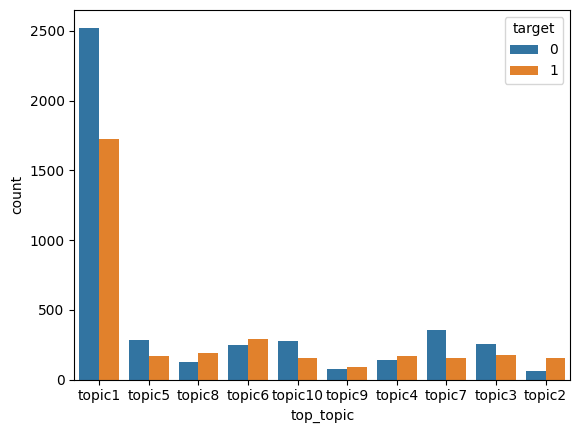

In [14]:
#plot the distribution of the top topic for each document
# sns.countplot(x='top_topic', data=df, hue='target')
# plt.show()

##### LDA (Jac)

In [213]:
# Jac's part

from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

dictionary = Dictionary(df['nostopwords_text'])
corpus = [dictionary.doc2bow(text) for text in df['nostopwords_text']]

For num_topics:  1 coherence scores per topic:  [0.4263997674222912]
For num_topics:  2 coherence scores per topic:  [0.42320313320181385, 0.3726461131156272]
For num_topics:  3 coherence scores per topic:  [0.48173300093695415, 0.478062609687091, 0.4389669940841313]
For num_topics:  4 coherence scores per topic:  [0.36142346675321313, 0.4926776906340951, 0.3935606647661462, 0.5406062598878904]
For num_topics:  5 coherence scores per topic:  [0.43827552065134734, 0.43108532855511134, 0.5520846228478676, 0.5746445416592194, 0.5655634104284276]
For num_topics:  6 coherence scores per topic:  [0.45945874752083016, 0.4712107093533634, 0.5715981566662001, 0.5278534767712921, 0.6141832229051997, 0.42562530223411]
For num_topics:  7 coherence scores per topic:  [0.4840356821444759, 0.5100886108372474, 0.5383002821584065, 0.49677992390862524, 0.5943154131113448, 0.5143277846197496, 0.5056615737303105]


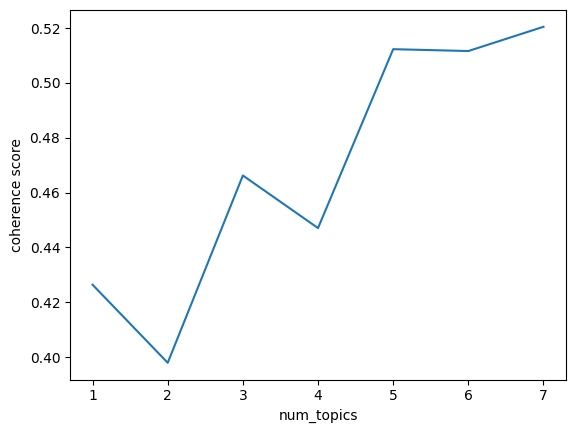

In [255]:
coh_scores = []
num_topics = []
for i in range(1,8):
    ldamodel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=i, random_state=100)
    cm = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=df['nostopwords_text'])
    coh_scores.append(cm.get_coherence())
    print('For num_topics: ', i, 'coherence scores per topic: ', cm.get_coherence_per_topic())
    num_topics.append(i)

plt.plot(num_topics, coh_scores)
plt.xlabel('num_topics')
plt.ylabel('coherence score')
plt.show()

For num_topics:  1 coherence scores per topic:  [0.4263997674222912]
For num_topics:  2 coherence scores per topic:  [0.34428082766019064, 0.5013003952374897]
For num_topics:  3 coherence scores per topic:  [0.435542714933581, 0.4558955271064094, 0.4869631977570303]
For num_topics:  4 coherence scores per topic:  [0.3915993295383811, 0.49156740407302485, 0.48530113395240615, 0.5492562544079715]
For num_topics:  5 coherence scores per topic:  [0.4807027637973923, 0.4942059570266627, 0.49220989161306966, 0.5750223346902245, 0.45868718707280776]
For num_topics:  6 coherence scores per topic:  [0.4214720231864876, 0.5520499695478752, 0.5044340209661821, 0.6289744876290614, 0.4612669038515529, 0.5421410634186888]
For num_topics:  7 coherence scores per topic:  [0.39724503019135876, 0.559241995564079, 0.47763719881711236, 0.6191894093618961, 0.43146275840568277, 0.5433203002018996, 0.5914732996257427]


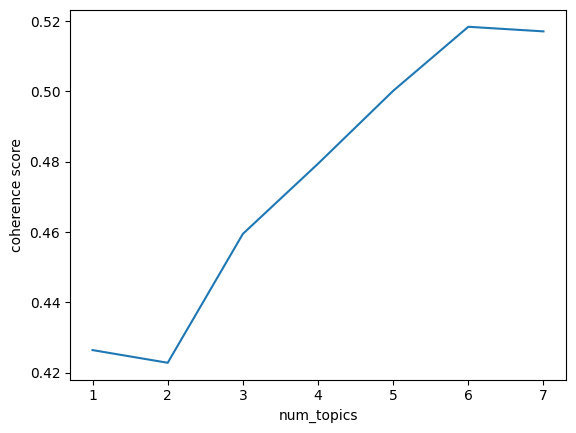

In [467]:
coh_scores = []
num_topics = []
for i in range(1,8):
    ldamodel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=i, random_state=123)
    cm = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=df['nostopwords_text'])
    coh_scores.append(cm.get_coherence())
    print('For num_topics: ', i, 'coherence scores per topic: ', cm.get_coherence_per_topic())
    num_topics.append(i)

plt.plot(num_topics, coh_scores)
plt.xlabel('num_topics')
plt.ylabel('coherence score')
plt.show()

For num_topics:  5 coherence scores per topic:  [0.5091014886982099, 0.5604277189338721, 0.36774329679187867, 0.499972528797176, 0.481925144288451]
For num_topics:  6 coherence scores per topic:  [0.5814615133096194, 0.43374304713306816, 0.45430601686535016, 0.36953540605249724, 0.5125219484122074, 0.5005948621182783]
For num_topics:  7 coherence scores per topic:  [0.606689900582933, 0.5082817689642727, 0.41286050376903505, 0.44465867506551165, 0.5062158512136685, 0.5967811210574332, 0.4616174204294577]


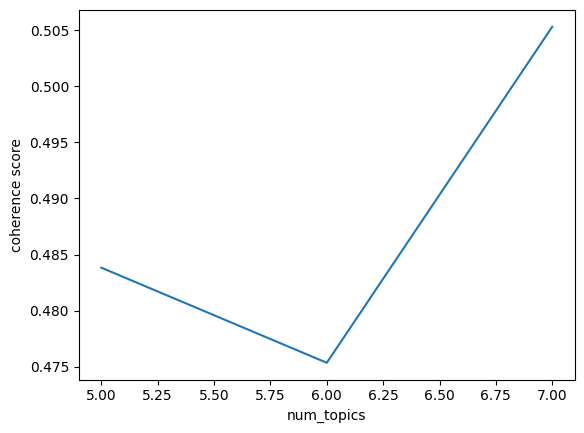

In [450]:
coh_scores = []
num_topics = []
for i in range(5,8):
    ldamodel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=i, random_state=2023)
    cm = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=df['nostopwords_text'])
    coh_scores.append(cm.get_coherence())
    print('For num_topics: ', i, 'coherence scores per topic: ', cm.get_coherence_per_topic())
    num_topics.append(i)

plt.plot(num_topics, coh_scores)
plt.xlabel('num_topics')
plt.ylabel('coherence score')
plt.show()

For num_topics:  6 coherence scores per topic:  [0.4214720231864876, 0.5520499695478752, 0.5044340209661821, 0.6289744876290614, 0.4612669038515529, 0.5421410634186888]

In [468]:
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=7, random_state=123)

In [469]:
topics = lda_model.show_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.017*"im" + 0.011*"traumatised" + 0.011*"violent" + 0.010*"fires" + 0.009*"weapons" + 0.008*"like" + 0.007*"people" + 0.007*"officer" + 0.007*"war" + 0.006*"world" + 0.006*"wild" + 0.006*"video" + 0.005*"û" + 0.005*"dead" + 0.005*"got" + 0.005*"police" + 0.005*"still" + 0.005*"wreck" + 0.005*"amp" + 0.004*"year"')
(1, '0.009*"fire" + 0.007*"û" + 0.006*"wildfire" + 0.006*"new" + 0.005*"trouble" + 0.005*"amp" + 0.005*"confirmed" + 0.005*"rules" + 0.005*"plane" + 0.005*"landing" + 0.005*"rescued" + 0.004*"sinking" + 0.004*"news" + 0.004*"us" + 0.004*"near" + 0.004*"injuries" + 0.004*"help" + 0.004*"teen" + 0.003*"glad" + 0.003*"half"')
(2, '0.015*"thunderstorm" + 0.013*"wounds" + 0.012*"storm" + 0.012*"û" + 0.010*"thunder" + 0.007*"wildfire" + 0.006*"video" + 0.006*"ûªs" + 0.006*"news" + 0.006*"via" + 0.005*"disaster" + 0.005*"california" + 0.005*"one" + 0.004*"youtube" + 0.004*"latest" + 0.004*"survivors" + 0.004*"rain" + 0.004*"photo" + 0.004*"hurricane" + 0.004*"county"')
(3, '0.

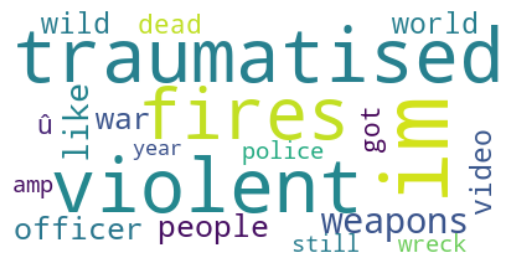

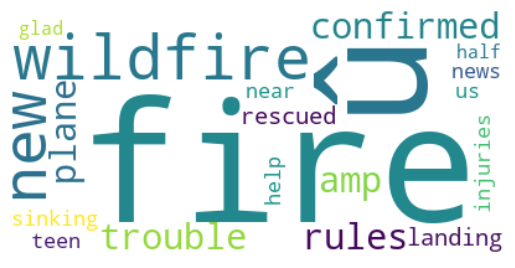

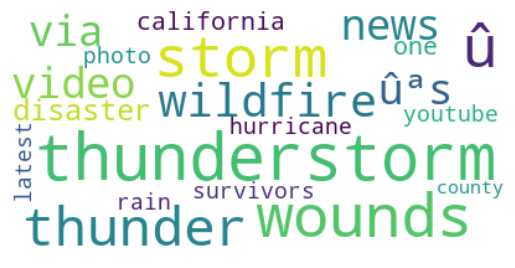

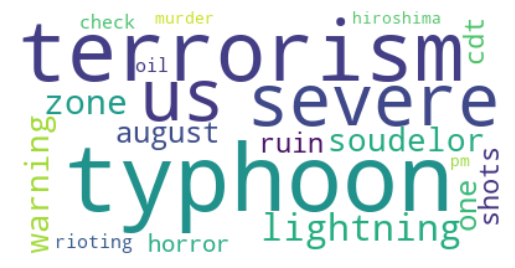

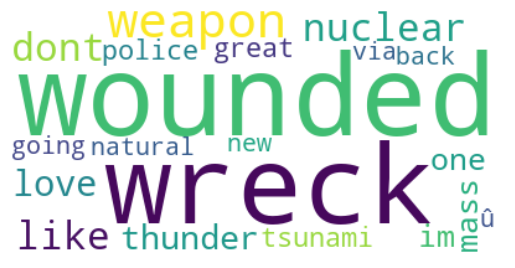

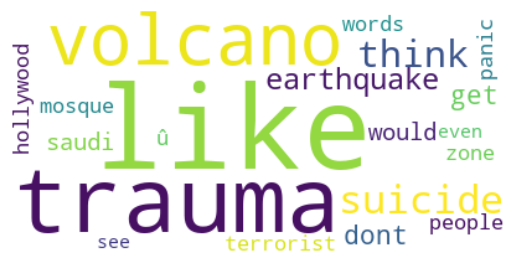

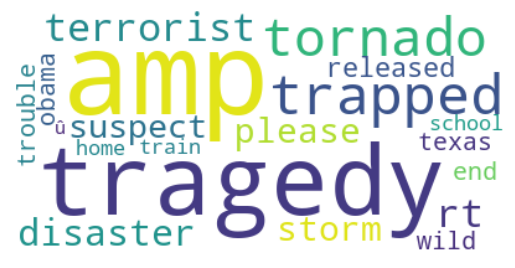

In [470]:
for i in range(len(topics)):
    topic_result = topics[i]
    # Extract words and their weights from topic result
    words = topic_result[1].split(' + ')
    word_weights = {}
    for word in words:
        weight, word = word.split('*')
        weight = float(weight)
        word = word.strip('"')
        word_weights[word] = weight

    # Create and display word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_weights)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [400]:
for i in range(len(topics)):
    df['topic'+str(i+1)]= np.nan


In [442]:
# put weights for each topic per document in the dataframe
for i, row in enumerate(lda_model[corpus]):
    for j, topic in enumerate(topics):
        if j < len(row):
            df.at[i, 'topic'+str(j+1)] = row[j][1]

In [445]:
df.tail()

,id,text,target,tokenized,nostopwords_text,topic1,topic2,topic3,topic4,topic5,topic6
6913,10860,a siren just went off and it wasnt the forney ...,1,"[a, siren, just, went, off, and, it, wasnt, th...","[siren, went, wasnt, forney, tornado, warning]",0.023982,0.023854,0.023891,0.024298,0.716712,0.187264
6914,10862,officials say a quarantine is in place at an a...,1,"[officials, say, a, quarantine, is, in, place,...","[officials, say, quarantine, place, alabama, h...",0.013964,0.319312,0.013927,0.624892,0.013959,0.013947
6915,10863,worldnews fallen powerlines on glink tram upda...,1,"[worldnews, fallen, powerlines, on, glink, tra...","[worldnews, fallen, powerlines, glink, tram, u...",0.013942,0.013968,0.176423,0.013916,0.767825,0.013927
6916,10864,on the flip side im at walmart and there is a ...,1,"[on, the, flip, side, im, at, walmart, and, th...","[flip, side, im, walmart, bomb, everyone, evac...",0.176983,0.015193,0.251262,0.015264,0.525964,0.015334
6917,10866,suicide bomber kills in saudi security site m...,1,"[suicide, bomber, kills, in, saudi, security, ...","[suicide, bomber, kills, saudi, security, site...",0.011993,0.011949,0.126760,0.011961,0.291272,0.546064


In [446]:
#based on the topic distribution, create a new column with the top topic for each document
df['top_topic'] = df[['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6']].idxmax(axis=1)
df.head()

,id,text,target,tokenized,nostopwords_text,topic1,topic2,topic3,topic4,topic5,topic6,top_topic
0,1,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",0.020886,0.020971,0.020880,0.020943,0.020872,0.895448,topic6
1,4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",0.021112,0.021277,0.020998,0.020995,0.894585,0.021034,topic5
2,5,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",0.013937,0.930258,0.013936,0.013993,0.013926,0.013951,topic2
3,6,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",0.024035,0.879959,0.024003,0.023887,0.023998,0.024117,topic2
4,7,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",0.738026,0.017289,0.194184,0.016803,0.016840,0.016857,topic1


In [447]:
df['top_topic']= df['top_topic'].str.replace(r'\D+', '')

# Convert column 'top_topic' from string to integer
df['top_topic'] = df['top_topic'].astype(int)

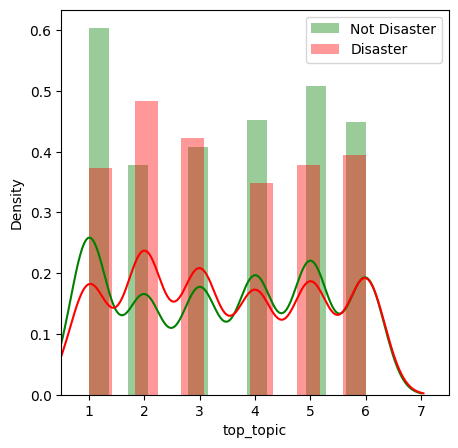

In [448]:
# plot the distribution of the top topic for each document
fig, axes = plt.subplots( figsize=(5, 5), dpi=100)


sns.distplot(df.loc[df['target'] == 0]['top_topic'], label='Not Disaster', color='green')
sns.distplot(df.loc[df['target'] == 1]['top_topic'], label='Disaster', color='red')
plt.xlim(0.5, 7.5)
plt.legend()

For num_topics:  6 coherence scores per topic:  [0.46367855586117923, 0.5961266576120676, 0.5428232837620663, 0.5417766963085906, 0.47374273083093305, 0.41737556453920066]
For num_topics:  7 coherence scores per topic:  [0.5217083703573164, 0.5091382748884111, 0.5117399717207581, 0.5821068293661662, 0.5286006216723215, 0.46444110587151943, 0.5594518391070068]
For num_topics:  8 coherence scores per topic:  [0.5004675047773491, 0.4706311126962917, 0.5385410990070875, 0.5658613269290077, 0.5172569799626945, 0.48127649491433316, 0.5670734684367672, 0.5185564687542363]
For num_topics:  9 coherence scores per topic:  [0.5346415718560182, 0.6561911833303566, 0.539146165049478, 0.6008766837018232, 0.4226998167564844, 0.5571190132540186, 0.5883699229114103, 0.6147704927404702, 0.5172575200454073]


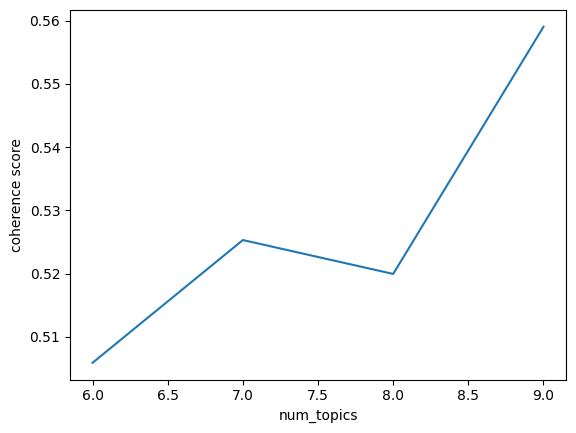

In [219]:
coh_scores = []
num_topics = []
for i in range(6,10):
    ldamodel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=i, random_state=0)
    cm = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=df['nostopwords_text'])
    coh_scores.append(cm.get_coherence())
    print('For num_topics: ', i, 'coherence scores per topic: ', cm.get_coherence_per_topic())
    num_topics.append(i)

plt.plot(num_topics, coh_scores)
plt.xlabel('num_topics')
plt.ylabel('coherence score')
plt.show()

For num_topics:  5 coherence scores per topic:  [0.566058982892991, 0.5392244673372264, 0.5290529125180988, 0.4504760176068346, 0.4919438383097291]
For num_topics:  10 coherence scores per topic:  [0.5527049297267377, 0.5264816558672313, 0.5396553100146666, 0.5315086813730956, 0.4710469069410134, 0.553942958399524, 0.5334033033827832, 0.459102697344575, 0.5467963599906487, 0.6430481961190921]
For num_topics:  15 coherence scores per topic:  [0.4644983539657918, 0.6774476782044254, 0.5932825064600131, 0.48484828546092207, 0.444461976422303, 0.5211983470254877, 0.5486278036782821, 0.5649450960082908, 0.584484747317351, 0.5093696610888717, 0.5829216166952605, 0.5558747172196451, 0.5679318992342741, 0.6106931214938903, 0.5744608746925591]


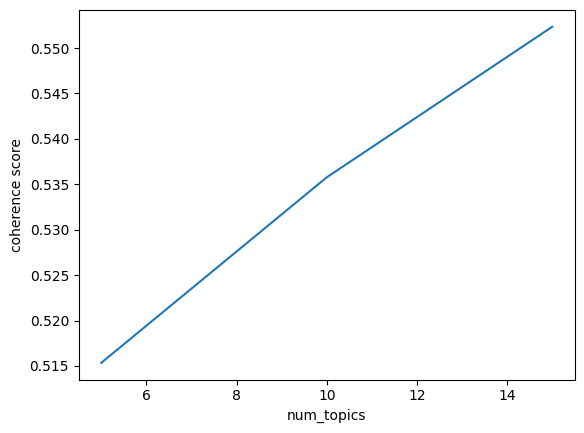

In [220]:
coh_scores = []
num_topics = []
for i in range(5,20,5):
    ldamodel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=i, random_state=0)
    cm = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=df['nostopwords_text'])
    coh_scores.append(cm.get_coherence())
    print('For num_topics: ', i, 'coherence scores per topic: ', cm.get_coherence_per_topic())
    num_topics.append(i)

plt.plot(num_topics, coh_scores)
plt.xlabel('num_topics')
plt.ylabel('coherence score')
plt.show()

In [465]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
count_data = count_vectorizer.fit_transform(df['nostopwords_text'].apply(lambda x: ' '.join(x)))
vocab = count_vectorizer.get_feature_names()

n, m = count_data.shape
print('Number of documents: ', n)
k = 6

#build the LDA model using sklearn
lda_model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='online', random_state=0)
lda_model.fit(count_data)

#find the top 10 words in each topic
def print_topics(model, n_top_words):
    topic_word = model.components_

    for j in range(m):
        topic_word[:,j] /= sum(topic_word[:,j])
    for i in range(k):
        proj_j = []
        for j in range(m):
            proj_j.append((topic_word[i,j],j))
        
        prob_sorted = sorted(proj_j, reverse=True)
        print('topic',i+1)
        for j in range(n_top_words):
            print('    ', prob_sorted[j][0], vocab[prob_sorted[j][1]])

print_topics(lda_model, 10)

Number of documents:  6918
topic 1
     0.9941064080693278 video
     0.9940126898226725 emergency
     0.9916287455100614 rt
     0.9908942688396841 youtube
     0.9872106733508078 accident
     0.0024444203459784756 years
     0.0023810939617466445 hiroshima
     0.0023041874741857532 train
     0.002297918390968135 help
     0.0022700297981278804 make
topic 2
     0.9975065790530662 like
     0.9969808467764805 amp
     0.9939392902897852 suicide
     0.9938698756344392 police
     0.9931295708894936 disaster
     0.9922337537809252 day
     0.9914067232969689 fires
     0.9910963974624377 body
     0.9910409599853058 california
     0.9907412526152874 dead
topic 3
     0.9932876611551696 storm
     0.9901055088508139 life
     0.9895328506824462 today
     0.9887698163483875 car
     0.9885094815265676 help
     0.9884750119676379 train
     0.9880887728233364 hiroshima
     0.9877763936878907 years
     0.002560991792165352 accident
     0.0022693625074300164 make
topic 4
     0.9

In [457]:
#create dataframe with the topic distribution for each document
topic_dist = lda_model.transform(count_data)
topic_dist = pd.DataFrame(topic_dist)
topic_dist.columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6']
topic_dist.head()


,topic1,topic2,topic3,topic4,topic5,topic6
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.055556,0.388876,0.055556,0.055556,0.388902,0.055556
4,0.083333,0.083333,0.083333,0.083333,0.083333,0.583333


In [456]:
df= df.drop(['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'top_topic'], axis=1)

In [458]:
#append the topic distribution to the original dataframe
df = pd.concat([df, topic_dist], axis=1)
df.head()

,id,text,target,tokenized,nostopwords_text,topic1,topic2,topic3,topic4,topic5,topic6
0,1,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,5,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,6,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",0.055556,0.388876,0.055556,0.055556,0.388902,0.055556
4,7,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",0.083333,0.083333,0.083333,0.083333,0.083333,0.583333


In [459]:
#based on the topic distribution, create a new column with the top topic for each document
df['top_topic'] = df[['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6']].idxmax(axis=1)
df.head()

,id,text,target,tokenized,nostopwords_text,topic1,topic2,topic3,topic4,topic5,topic6,top_topic
0,1,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,topic1
1,4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,topic1
2,5,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,topic1
3,6,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",0.055556,0.388876,0.055556,0.055556,0.388902,0.055556,topic5
4,7,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",0.083333,0.083333,0.083333,0.083333,0.083333,0.583333,topic6


In [461]:
df['top_topic']= df['top_topic'].str.replace(r'\D+', '')

# Convert column 'A' from string to integer
df['top_topic'] = df['top_topic'].astype(int)

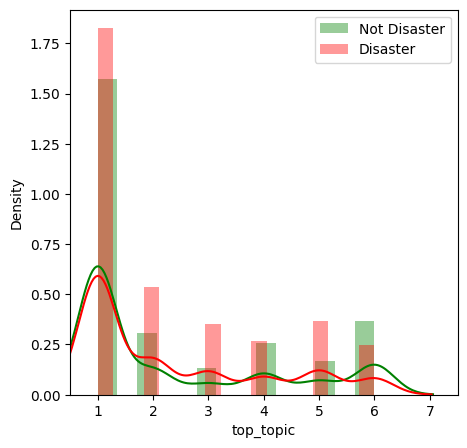

In [462]:

fig, axes = plt.subplots( figsize=(5, 5), dpi=100)


sns.distplot(df.loc[df['target'] == 0]['top_topic'], label='Not Disaster', color='green')
sns.distplot(df.loc[df['target'] == 1]['top_topic'], label='Disaster', color='red')
plt.xlim(0.5, 7.5)
plt.legend()

### Word Clouds

Topic#  1
video,emergency,rt,youtube,accident,years,hiroshima,train,help,make,car,want,way,killed,war,buildings,today,ûªs,attack,life

Topic#  2
like,amp,suicide,police,disaster,day,fires,body,california,dead,killed,know,accident,years,hiroshima,train,help,make,car,want

Topic#  3
storm,life,today,car,help,train,hiroshima,years,accident,make,want,way,killed,war,buildings,ûªs,attack,think,burning,good

Topic#  4
new,world,nuclear,going,love,good,think,attack,ûªs,war,accident,years,hiroshima,train,help,make,car,want,way,killed

Topic#  5
news,people,bomb,say,crash,way,accident,years,hiroshima,train,help,make,car,want,killed,war,buildings,today,ûªs,attack

Topic#  6
im,dont,got,time,man,burning,buildings,want,make,know,accident,years,hiroshima,train,help,car,way,killed,war,today



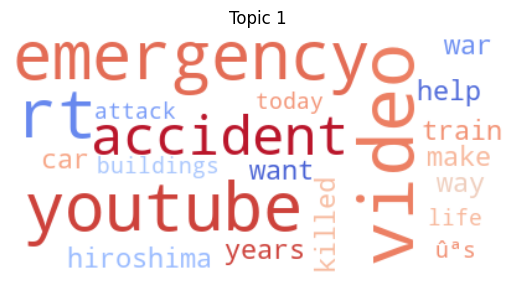

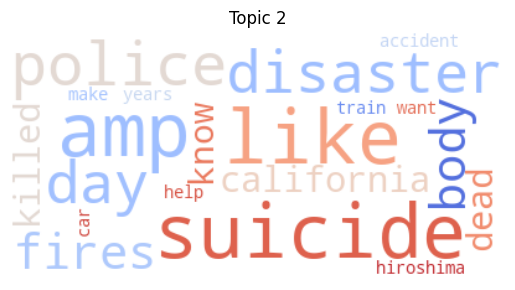

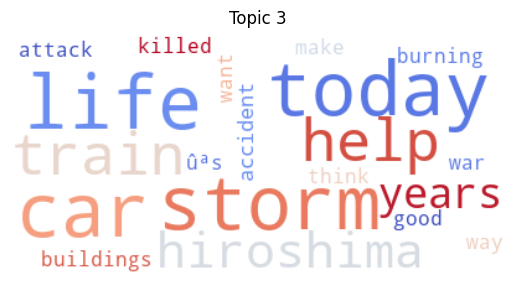

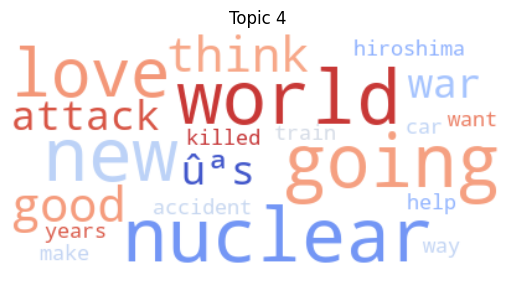

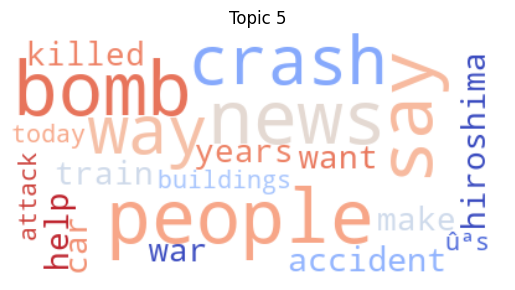

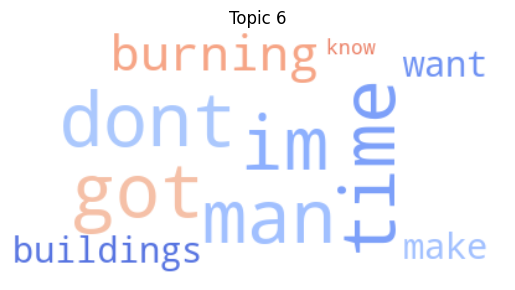

In [466]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # Ignore deprecation warnings


terms_count = 20
for idx,topic in enumerate(lda_model.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[vocab[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[vocab[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
        wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
        contour_width=1,contour_color='black', colormap= 'coolwarm')
        wcloud.generate_from_frequencies(dict_word_frequency)

    plt.figure()
    plt.title(f'Topic {idx+1}')
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")